In [1]:
import os

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
gpu_index = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_index
os.environ['HF_HOME'] = '../huggingface_cache/'      # Cache directory for huggingface.
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [2]:
# import sys
# sys.path.insert(1, os.path.join(sys.path[0], '../'))

In [3]:
import torch
import torchvision
from transformers import AutoConfig, AutoTokenizer
from transformers.models.vit.modeling_vit import ViTLayer
from transformers.models.distilbert.modeling_distilbert import TransformerBlock
import itertools
import dataclasses
from tqdm import tqdm
import copy
from IPython.display import clear_output

In [4]:
import random
import numpy as np

# Set a seed value
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

gen = torch.Generator()
gen.manual_seed(seed)

In [5]:
from data_manager import get_simple_transform, get_img_transform, TargetTransformCoco, seed_worker
from model import ImageEncoder, TextEncoder, ProjectionHead, ClipCoco, prep_text_model_prog, prep_img_model_prog
from train_val_manager import train_clip_coco, val_clip_coco, comp_cost, get_model_size
import federated_learning as fl
from configs import PROG_CLIP_COCO_FL
import utils

In [6]:
CFG = PROG_CLIP_COCO_FL.Config()
print(dataclasses.asdict(CFG))

{'device': device(type='cuda'), 'train_dir': '../datasets/coco_ratio/train2017', 'train_anno_dir': '../datasets/coco_ratio/annotations/captions_train2017.json', 'val_dir': '../datasets/coco_ratio/val2017', 'val_anno_dir': '../datasets/coco_ratio/annotations/captions_val2017.json', 'img_size': 224, 'batch_size': 32, 'num_workers': 2, 'prefetch_factor': 2, 'img_enc_name': 'WinKawaks/vit-tiny-patch16-224', 'img_feat_dim': 192, 'interpolate_pos_encoding': False, 'text_enc_name': 'distilbert-base-uncased', 'text_feat_dim': 768, 'max_length': 40, 'hidden_dim': 4096, 'projection_dim': 256, 'dropout': 0.1, 'num_layers': 3, 'base_head_lr': 0.0001, 'base_img_enc_lr': 1e-07, 'base_text_enc_lr': 1e-05, 'head_lr': 1.25e-05, 'img_enc_lr': 1.25e-08, 'text_enc_lr': 1.25e-06, 'weight_decay': 1e-06, 'temperature': 0.05, 'num_local_epochs': 3, 'num_clients': 10, 'active_num_clients': None, 'valid_client_ratio': None, 'set_num': '90_uni_lr', 'num_stages': 6, 'num_epochs': (15, 15, 15, 15, 15, 15), 'num_im

In [7]:
save_dir = os.path.join(
    './output/PROG_CLIP_COCO_FL/', 
    'b_{}_nc_{}'.format(
        CFG.batch_size,
        CFG.num_clients,
    )
)
save_dir = '{}_anc_{}'.format(save_dir, CFG.active_num_clients) if CFG.active_num_clients else save_dir
save_dir = '{}_vcr_{}'.format(save_dir, CFG.valid_client_ratio) if CFG.valid_client_ratio else save_dir
save_dir = '{}_set_{}'.format(save_dir, CFG.set_num)

os.makedirs(save_dir, exist_ok=True)
print(save_dir)

base_pretrained_dir = './pretrained_weights'
img_pretrained_dir = os.path.join(base_pretrained_dir, CFG.img_enc_name.split('/')[-1])
text_pretrained_dir = os.path.join(base_pretrained_dir, CFG.text_enc_name.split('/')[-1])

./output/PROG_CLIP_COCO_FL/b_32_nc_10_set_90_uni_lr


In [8]:
# Prepare data.
simple_transform = get_simple_transform(img_size=CFG.img_size)
img_transform = get_img_transform(img_size=CFG.img_size)
target_transform_coco = TargetTransformCoco()

train_dataset = torchvision.datasets.CocoCaptions(
    root=CFG.train_dir,
    annFile=CFG.train_anno_dir,
    transform=img_transform,
    target_transform=target_transform_coco,
)
print('len(train_dataset):', len(train_dataset))

loading annotations into memory...
Done (t=1.06s)
creating index...
index created!
len(train_dataset): 118287


In [9]:
# Define client data.
client_loaders = []
num_img = len(train_dataset) // CFG.num_clients    # Train images per client.
print('num_img:', num_img)
img_idx = 0 
for client_idx in range(CFG.num_clients):
    client_dataset = torch.utils.data.Subset(train_dataset, range(img_idx, img_idx + num_img))
    client_loader = torch.utils.data.DataLoader(
        client_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=CFG.num_workers,
        persistent_workers=True,
        pin_memory=True,
        prefetch_factor=CFG.prefetch_factor,
        worker_init_fn=seed_worker,
        generator=gen,
    )
    client_loaders.append(client_loader)
    img_idx += num_img

num_img: 11828


In [10]:
val_dataset = torchvision.datasets.CocoCaptions(
    root=CFG.val_dir,
    annFile=CFG.val_anno_dir,
    transform=simple_transform,
    target_transform=target_transform_coco,
)
print('len(val_dataset):', len(val_dataset))
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=CFG.num_workers,
    persistent_workers=True,
    pin_memory=True,
    prefetch_factor=CFG.prefetch_factor,
    generator=gen,
)

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
len(val_dataset): 5000


In [11]:
# dataiter = iter(val_loader)
# img, cap = next(dataiter)

# utils.show_img_tensor(img[0])
# print(cap[0])

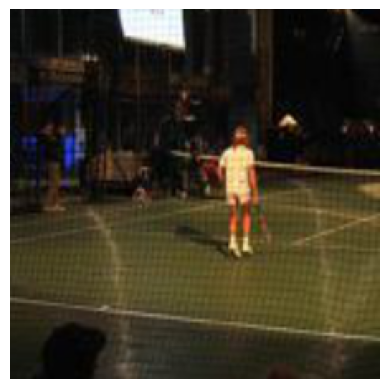

Two people play tennis against a dark backdrop.


In [12]:
dataiter = iter(client_loaders[0])
img, cap = next(dataiter)

utils.show_img_tensor(img[0])
print(cap[0])

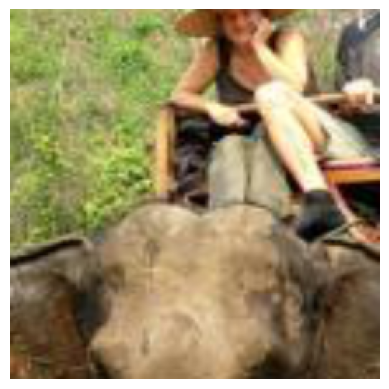

a couple wearing hats are riding an elephant


In [13]:
dataiter = iter(client_loaders[-1])
img, cap = next(dataiter)

utils.show_img_tensor(img[0])
print(cap[0])

In [14]:
# img, cap = client_loaders[0].dataset[-1]
# utils.show_img_tensor(img)
# print(cap)

In [15]:
tokenizer = AutoTokenizer.from_pretrained(CFG.text_enc_name)

# Initialize encoder configurations.
img_enc_config = AutoConfig.from_pretrained(CFG.img_enc_name)
text_enc_config = AutoConfig.from_pretrained(CFG.text_enc_name)

img_enc_config.num_hidden_layers = 0
text_enc_config.num_hidden_layers = 0

In [16]:
# Encoders.
lw_img_enc = ImageEncoder(config=img_enc_config)
lw_text_enc = TextEncoder(config=text_enc_config)

# Projection heads.
img_proj_head = ProjectionHead(CFG.img_feat_dim, CFG.hidden_dim, CFG.projection_dim, CFG.num_layers, CFG.dropout)
text_proj_head = ProjectionHead(CFG.text_feat_dim, CFG.hidden_dim, CFG.projection_dim, CFG.num_layers, CFG.dropout)

In [17]:
# For logging model performance.
metric_keys = ['train_loss', 'test_loss', 'restart_stage', 'restart_epoch', 'model_size']
_, performance_log = utils.get_performance_loggers(metric_keys)
performance_log['lr'] = {}

client_log = {}
for client_idx in range(CFG.num_clients):
    client_log[client_idx] = {}

In [18]:
# Automatic resuming.
start_stage = 0
start_epoch = 0
skip_prep_model = False

log_path = os.path.join(save_dir, 'performance_log.pickle')
client_log_path = os.path.join(save_dir, 'client_log.pickle')
ckpt_path = os.path.join(save_dir, 'ckpt_bundle.pth')
if os.path.isfile(log_path):
    performance_log = utils.load_pickle(log_path)
    client_log = utils.load_pickle(client_log_path)
    ckpt_bundle = torch.load(ckpt_path)
    
    start_stage = ckpt_bundle['stage']
    start_epoch = ckpt_bundle['epoch'] + 1     # 1 is added since we save after finishing the epoch. So we start at next.

    performance_log['restart_stage'].append(start_stage)
    performance_log['restart_epoch'].append(start_epoch)
    
    # Prepare encoders for this stage. 
    for num_img_layers, num_text_layers in zip(CFG.num_img_layers[:start_stage+1], CFG.num_text_layers[:start_stage+1]):
        lw_img_enc = prep_img_model_prog(lw_img_enc, num_img_layers, ViTLayer, img_pretrained_dir)
        lw_text_enc = prep_text_model_prog(lw_text_enc, num_text_layers, TransformerBlock, text_pretrained_dir)
    
    # CLIP model.
    clip_model = ClipCoco(lw_img_enc, lw_text_enc, img_proj_head, text_proj_head)
    clip_model.load_state_dict(ckpt_bundle['clip_model'])
    clip_model = clip_model.to(CFG.device)

    skip_prep_model = True

In [19]:
start_epoch = 0

In [20]:
%%time
# Clients with enough compute.
if CFG.valid_client_ratio:
    CFG.num_clients = int(CFG.num_clients * CFG.valid_client_ratio)
    
for stage in range(start_stage, CFG.num_stages):
    clear_output(wait=True)
    
    utils.print_separator(text='Stage: {} / {}'.format(stage + 1, CFG.num_stages))

    # Parameters for this stage.
    num_epochs = CFG.num_epochs[stage]
    num_img_layers = CFG.num_img_layers[stage]
    num_text_layers = CFG.num_text_layers[stage]
    if CFG.stage_lr:
        CFG.img_enc_lr = CFG.stage_img_lr[stage] * CFG.batch_size / 256 
        CFG.text_enc_lr = CFG.stage_text_lr[stage] * CFG.batch_size / 256
        CFG.head_lr = CFG.stage_head_lr[stage] * CFG.batch_size / 256
        
    # Prepare model for a new stage.
    # For automatic resuming training, model preparation is done above and skipped here.
    if not skip_prep_model:
        # Prepare encoders for this stage. 
        lw_img_enc = prep_img_model_prog(lw_img_enc, num_img_layers, ViTLayer, img_pretrained_dir)
        lw_text_enc = prep_text_model_prog(lw_text_enc, num_text_layers, TransformerBlock, text_pretrained_dir)

        # CLIP model.
        clip_model = ClipCoco(lw_img_enc, lw_text_enc, img_proj_head, text_proj_head)
        clip_model = clip_model.to(CFG.device)

        start_epoch = 0
    skip_prep_model = False

    # Training. FL rounds.
    for epoch in range(start_epoch, num_epochs):
        utils.print_separator(text='Epoch: {} / {}'.format(epoch + 1, num_epochs))

        val_result_dict = val_clip_coco(clip_model, val_loader, tokenizer, CFG)
        performance_log['test_loss'].append(val_result_dict['loss'])
        performance_log['model_size'].append(get_model_size(clip_model))    # Model size for sanity check.

        # Local training.
        if CFG.active_num_clients:
            active_clients = np.random.choice(range(CFG.num_clients), CFG.active_num_clients, replace=False)
            active_clients.sort()
        else:
            active_clients = range(CFG.num_clients)

        client_updates = dict()
        for client_idx in active_clients:
            torch.cuda.empty_cache()
            print('client:', client_idx)

            local_model = copy.deepcopy(clip_model)
            local_loader = client_loaders[client_idx]
            
            # Optimizer.
            params = [
                {'params': filter(lambda p: p.requires_grad, local_model.img_encoder.parameters()), 'lr': CFG.img_enc_lr, 'name': 'img_enc'},
                {'params': filter(lambda p: p.requires_grad, local_model.text_encoder.parameters()), 'lr': CFG.text_enc_lr, 'name': 'text_enc'},
                {'params': itertools.chain(
                    filter(lambda p: p.requires_grad, local_model.img_proj_head.parameters()),
                    filter(lambda p: p.requires_grad, local_model.text_proj_head.parameters()),
                ), 'lr': CFG.head_lr, 'weight_decay': CFG.weight_decay, 'name': 'proj_head'},
            ]
            local_optimizer = torch.optim.AdamW(params)

            # Local training loop.
            for local_epoch in range(CFG.num_local_epochs):
                gpu_time, gpu_mem, train_result_dict = comp_cost(
                    gpu_index, train_clip_coco, local_model, local_loader, tokenizer, local_optimizer, CFG
                )

                # Log for the first client. It is the same for all clients.
                if client_idx == 0:
                    for param_group in local_optimizer.param_groups:
                        performance_log['lr'].setdefault(param_group['name'], list()).extend(train_result_dict[param_group['name']])

                # Log local results.
                client_log[client_idx].setdefault('gpu_time', list()).append(gpu_time)
                client_log[client_idx].setdefault('gpu_mem', list()).append(gpu_mem)
                client_log[client_idx].setdefault('train_loss', list()).append(train_result_dict['loss'])

            # To calculate global weights and statistics.
            client_updates.setdefault('local_weights', list()).append(local_model.state_dict())
            client_updates.setdefault('num_samples', list()).append(len(local_loader.dataset))
            client_updates.setdefault('train_loss', list()).append(client_log[client_idx]['train_loss'][-1]) # Last loss from the client.

        # Aggregation.
        glob_weights = fl.weighted_averaging(client_updates['local_weights'], client_updates['num_samples'])
        clip_model.load_state_dict(glob_weights)
        performance_log['train_loss'].append(sum(client_updates['train_loss'])/len(client_updates['train_loss']))

        # Save latest check point.
        if (epoch + 1) % CFG.save_epoch == 0:
            ckpt_bundle = {
                'clip_model': clip_model.state_dict(),
            }
            torch.save(ckpt_bundle, ckpt_path)
            utils.save_pickle(log_path, performance_log)
            utils.save_pickle(client_log_path, client_log)
            clear_output(wait=True)
    
        for key in metric_keys:
            if len(performance_log[key]) > 0:
                print(key, '\t:', performance_log[key][-1])

train_loss 	: 0.32667713446042884
test_loss 	: 0.24759701786527208
model_size 	: 425.6274871826172
CPU times: user 17h 28min 6s, sys: 1h 38min 25s, total: 19h 6min 31s
Wall time: 20h 19s


In [21]:
ckpt_bundle = {
    'clip_model': clip_model.state_dict(),
    'stage': stage,
    'epoch': CFG.num_epochs[stage] - 1,
}
torch.save(ckpt_bundle, ckpt_path)
utils.save_pickle(log_path, performance_log)
utils.save_pickle(client_log_path, client_log)

In [22]:
torch.save(clip_model.state_dict(), os.path.join(save_dir, 'clip_model.pth'))

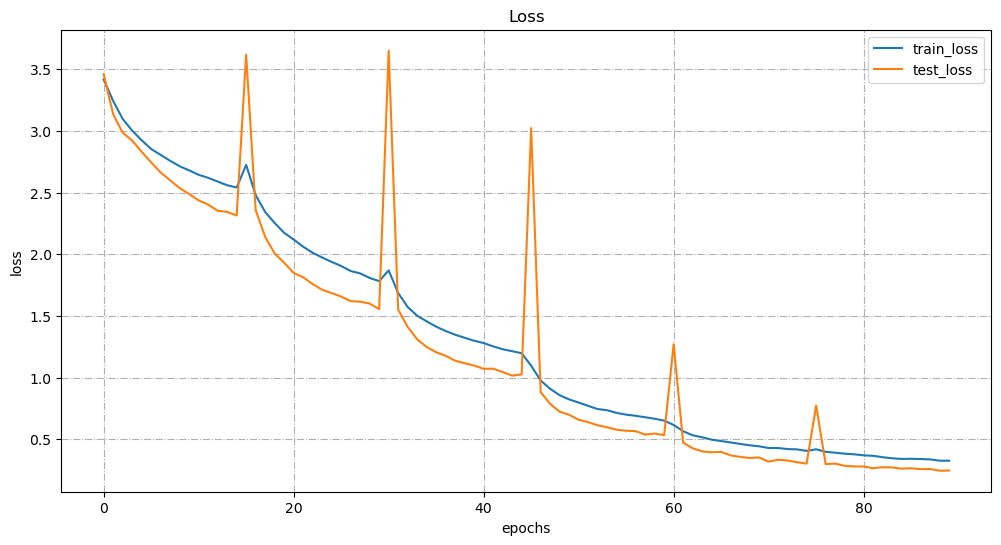

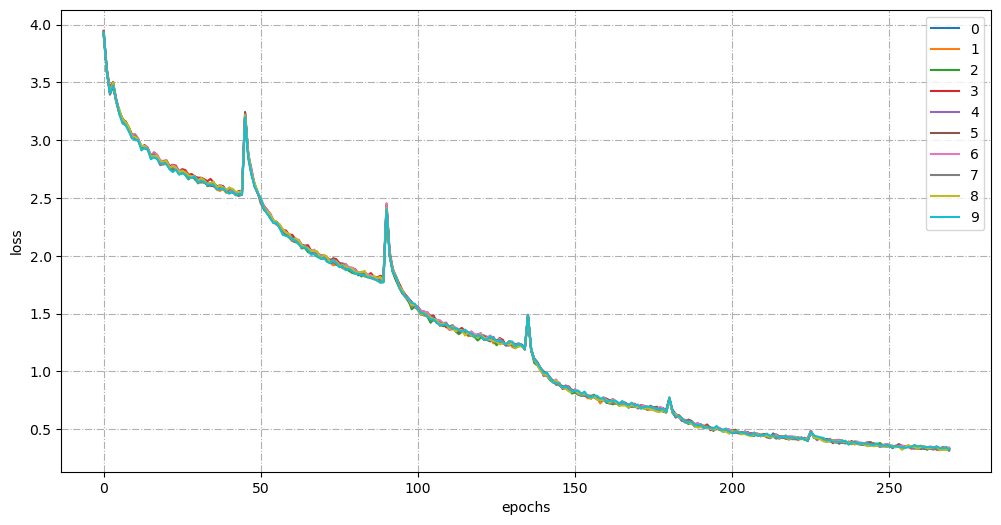

In [23]:
# Plot training history.
performance_log = utils.load_pickle(log_path)

loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['figsize'] = (12, 6)
loss_plot_config['save_dir'] = os.path.join(save_dir, 'loss.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
loss_plot_config['labels'] = ['train_loss', 'test_loss']
data_list = [performance_log['train_loss'], performance_log['test_loss']]
utils.save_plot(data_list, loss_plot_config)


client_log = utils.load_pickle(client_log_path)

loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['title'] = None
loss_plot_config['figsize'] = (12, 6)
loss_plot_config['save_dir'] = os.path.join(save_dir, 'client_loss.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
loss_plot_config['labels'] = [client_idx for client_idx in range(CFG.num_clients)]
data_list = [client_log[client_idx]['train_loss'] for client_idx in range(CFG.num_clients)]
utils.save_plot(data_list, loss_plot_config)

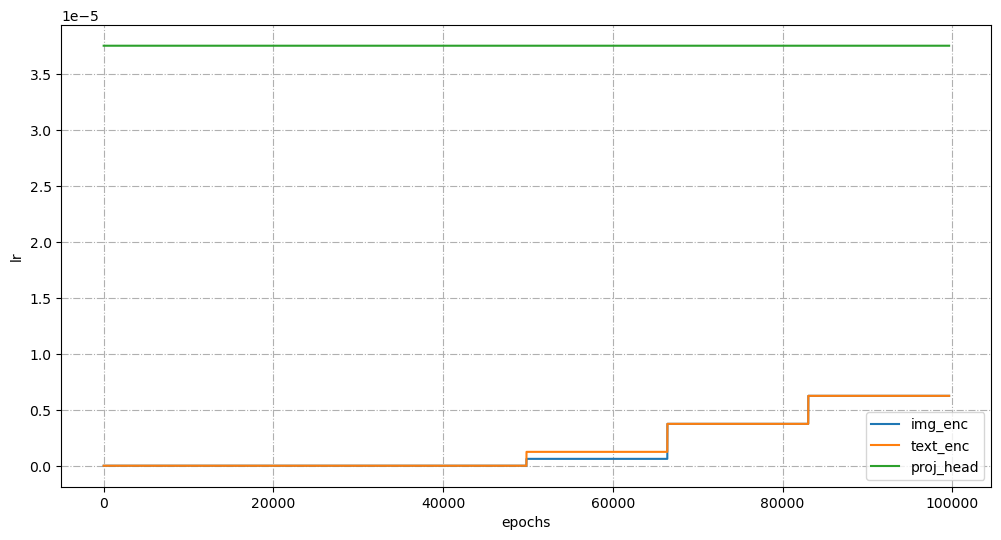

In [24]:
# Plot training history.
loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['title'] = None
loss_plot_config['figsize'] = (12, 6)
loss_plot_config['save_dir'] = os.path.join(save_dir, 'lr.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
loss_plot_config['ylabel'] = 'lr'
loss_plot_config['labels'] = [key for key in performance_log['lr'].keys()]
data_list = [performance_log['lr'][key] for key in performance_log['lr'].keys()]
utils.save_plot(data_list, loss_plot_config)

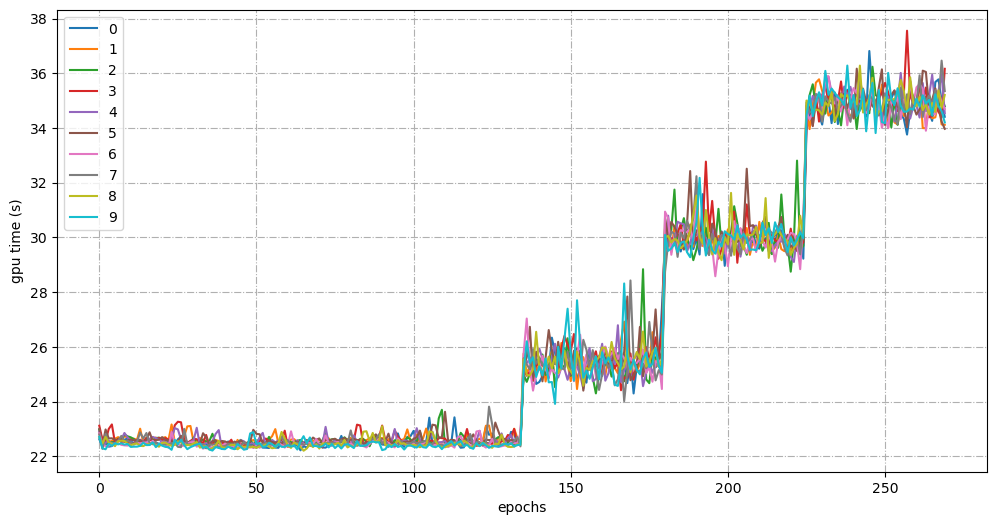

In [25]:
loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['title'] = None
loss_plot_config['figsize'] = (12, 6)
loss_plot_config['save_dir'] = os.path.join(save_dir, 'gpu_time.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
loss_plot_config['ylabel'] = 'gpu time (s)'
loss_plot_config['labels'] = [client_idx for client_idx in range(CFG.num_clients)]
data_list = [client_log[client_idx]['gpu_time'] for client_idx in range(CFG.num_clients)]
utils.save_plot(data_list, loss_plot_config)

In [26]:
client_time = utils.timeformat(sum(client_log[0]['gpu_time']))
print('client_time:', client_time)

total_time = utils.timeformat(sum([sum(client_log[idx]['gpu_time']) for idx in range(CFG.num_clients)]))
print('total_time:', total_time)

client_time: 01:58:10
total_time: 19:44:12


In [27]:
total_seconds = sum(client_log[0]['gpu_time'])
average = sum(client_log[0]['gpu_time']) / len(client_log[0]['gpu_time']) 

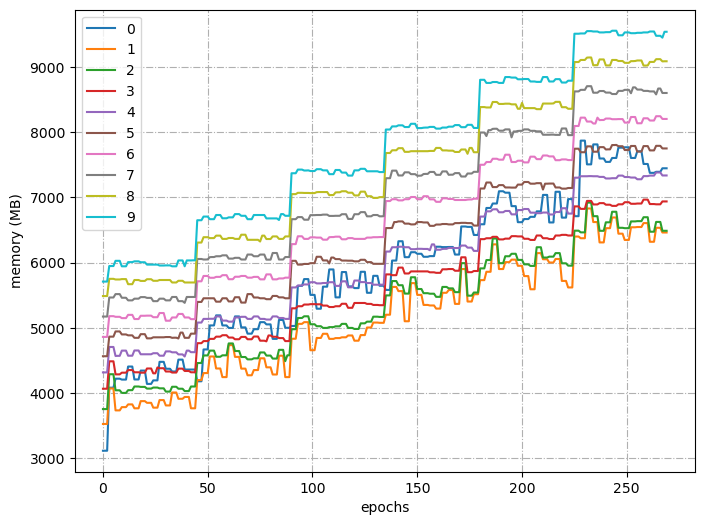

In [28]:
loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['title'] = None
loss_plot_config['save_dir'] = os.path.join(save_dir, 'gpu_mem.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
loss_plot_config['ylabel'] = 'memory (MB)'
loss_plot_config['labels'] = [client_idx for client_idx in range(CFG.num_clients)]
data_list = [client_log[client_idx]['gpu_mem'] for client_idx in range(CFG.num_clients)]
utils.save_plot(data_list, loss_plot_config)

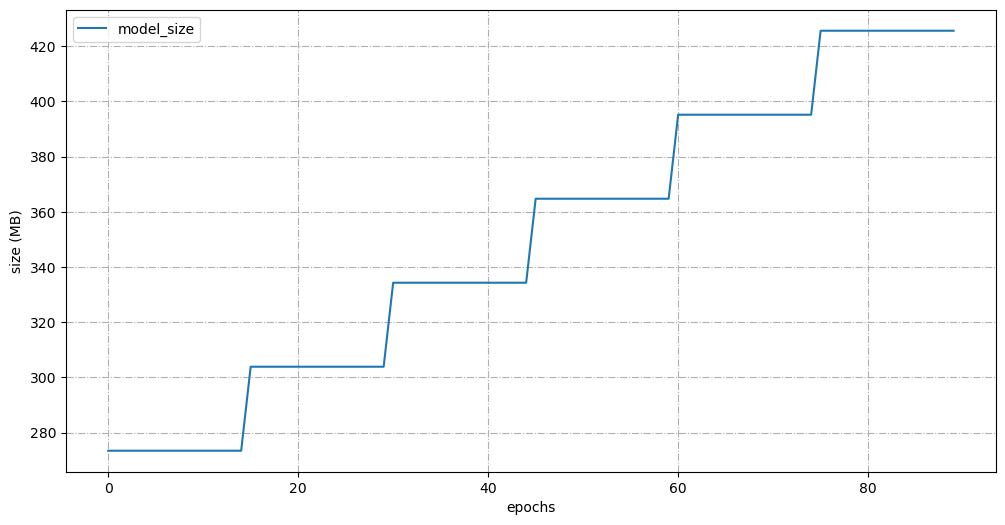

In [29]:
loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['title'] = None
loss_plot_config['figsize'] = (12, 6)
loss_plot_config['save_dir'] = os.path.join(save_dir, 'model_size.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
loss_plot_config['ylabel'] = 'size (MB)'
loss_plot_config['labels'] = ['model_size']
data_list = [performance_log['model_size']]
utils.save_plot(data_list, loss_plot_config)

### Image Retrieval

In [30]:
from train_val_manager import get_img_embed, get_similar_img_idxes

In [31]:
val_dataset = torchvision.datasets.CocoCaptions(
    root=CFG.val_dir,
    annFile=CFG.val_anno_dir,
    transform=simple_transform,
    target_transform=target_transform_coco,
)
print('len(val_dataset):', len(val_dataset))

# Don't shuffle. The indexes are required for retrival.
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=CFG.num_workers,
    persistent_workers=True,
    pin_memory=True,
    prefetch_factor=CFG.prefetch_factor,
)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
len(val_dataset): 5000


In [32]:
img_proj = get_img_embed(clip_model, val_loader, CFG)

100%|█████████████████████████████████████████| 157/157 [00:09<00:00, 16.31it/s]


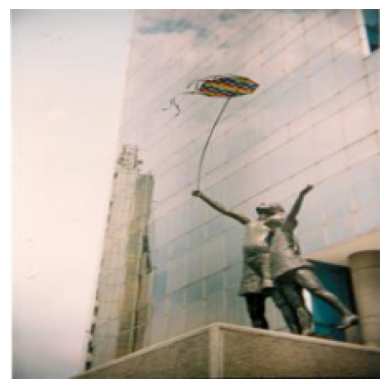

A statue of children flying a kite in front of a building.


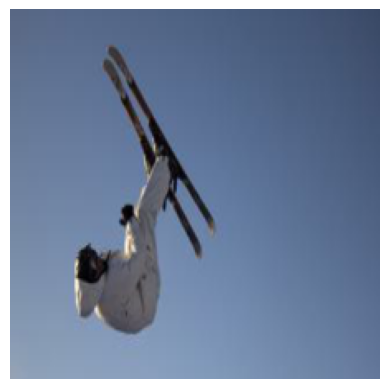

The snow skier is performing a flip in the air.


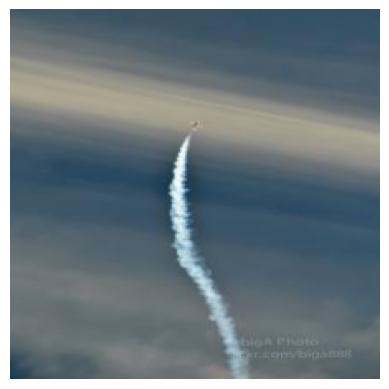

An airplane leaves a contrail in the air.


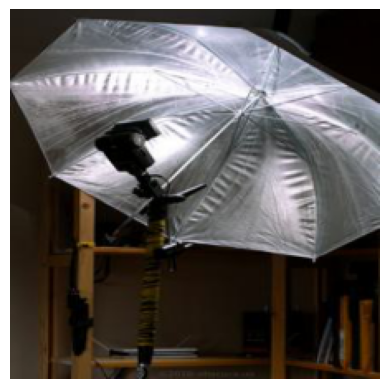

A digital camera beside an umbrella type photography lighting equipment


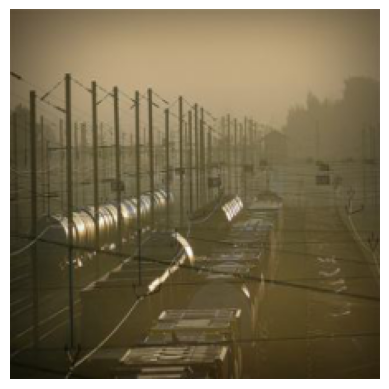

Railway cars in large yard with many power poles.


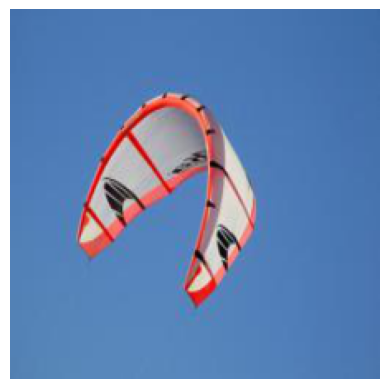

A large orange and white kite flying in a blue sky.


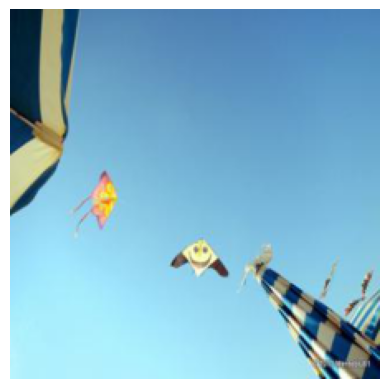

A few kites flying in the blue sky


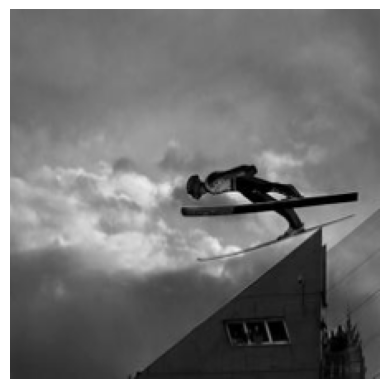

The skier is leaning forward while jumping through the air. 


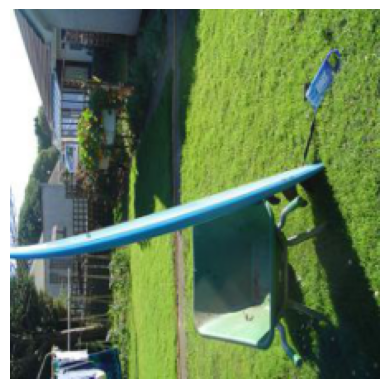

A wheelbarrow sitting in a field next to a surfboard.


In [33]:
values, indices = get_similar_img_idxes(
    query='air',
    img_proj=img_proj,
    tokenizer=tokenizer,
    clip_model=clip_model,
)

matches = [val_loader.dataset[idx] for idx in indices]
for i, c in matches:
    utils.show_img_tensor(i)
    print(c)

### Zero Shot

In [34]:
from data_manager import get_simple_transform, ImgDataset
from train_val_manager import zero_shot_acc

In [35]:
# STL-10
data_dir: str = '../datasets/stl_10/train'
# data_dir: str = '../datasets/stl_10/test'

# CIFAR-10
# data_dir: str = '../datasets/cifar_10/train'
# data_dir: str = '../datasets/cifar_10/test'

# CIFAR-100
# data_dir: str = '../datasets/cifar_100/train'
# data_dir: str = '../datasets/cifar_100/test'

In [36]:
simple_transform = get_simple_transform(img_size=CFG.img_size)

# Test data.
dataset = ImgDataset(data_dir, transform=simple_transform)
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=CFG.num_workers,
    persistent_workers=True,
    pin_memory=True,
    prefetch_factor=CFG.prefetch_factor,
)

In [37]:
acc = zero_shot_acc(tokenizer, clip_model, data_loader, CFG)
acc

100%|█████████████████████████████████████████| 157/157 [00:06<00:00, 23.18it/s]


0.8839570063694268

In [38]:
cfg_dict = dataclasses.asdict(CFG)
# cfg_dict.update(performance_log)
cfg_dict['device'] = cfg_dict['device'].type  # This gets a string since torch.device is not JSON serializable.
cfg_dict['zero_shot_acc'] = acc

### Image-to-Text and Text-to-Image 

In [39]:
from data_manager import TargetEncodeCoco
from train_val_manager import encode_dataset, recall_at_k

In [40]:
target_encode_coco = TargetEncodeCoco(tokenizer, padding='max_length', truncation=True, max_length=60)

retrieval_dataset = torchvision.datasets.CocoCaptions(
    root=CFG.val_dir,
    annFile=CFG.val_anno_dir,
    transform=simple_transform,
    # Note: almost all images have 5 captions, but 12/5000 have 6, and 1/5000 has 7 - I ignore these few extra captions.
    target_transform=target_encode_coco,
)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [41]:
retrieval_data_loader = torch.utils.data.DataLoader(
    retrieval_dataset,
    batch_size=256,
    shuffle=False,
    drop_last=False,
    num_workers=CFG.num_workers,
    persistent_workers=True,
    pin_memory=True,
    prefetch_factor=CFG.prefetch_factor,
)

In [42]:
image_encodings, text_encodings, text_to_image_map, image_to_text_map = encode_dataset(clip_model, retrieval_data_loader, CFG)

k_vals = [1, 5, 10, 50]
text_to_image_recall, image_to_text_recall = recall_at_k(image_encodings, text_encodings, text_to_image_map, image_to_text_map, k_vals)

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 99.40it/s]


In [43]:
print('Text-to-image Recall@K')
for k, x in zip(k_vals, text_to_image_recall):
    print('R@{}: {:.2f}%'.format(k, x*100))
    cfg_dict.setdefault('Text-to-Image', dict())['R@{}'.format(k)] = '{:.2f}%'.format(x*100)

print('Image-to-Text Recall@K')
for k, x in zip(k_vals, image_to_text_recall):
    print('R@{}: {:.2f}%'.format(k, x*100))
    cfg_dict.setdefault('Image-to-Text', dict())['R@{}'.format(k)] = '{:.2f}%'.format(x*100)

Text-to-image Recall@K
R@1: 21.02%
R@5: 47.92%
R@10: 62.26%
R@50: 90.26%
Image-to-Text Recall@K
R@1: 29.46%
R@5: 58.30%
R@10: 70.68%
R@50: 92.70%


In [44]:
client_time = utils.timeformat(sum(client_log[0]['gpu_time']))
total_time = utils.timeformat(sum([sum(client_log[idx]['gpu_time']) for idx in range(CFG.num_clients)]))
max_gpu_mem = str(max(client_log[0]['gpu_mem'])) + ' MB'

print('client_time:', client_time)
print('total_time:', total_time)
print('max_gpu_mem:', max_gpu_mem)

cfg_dict['client_time'] = client_time
cfg_dict['total_time'] = total_time
cfg_dict['max_gpu_mem'] = max_gpu_mem

utils.save_dict_json(os.path.join(save_dir, 'note.json'), cfg_dict)

client_time: 01:58:10
total_time: 19:44:12
max_gpu_mem: 7871 MB
